# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-undersampled-besra'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/netifier/oversampled.csv', encoding='latin-1')
data.shape

(9800, 5)

In [7]:
data.head()

,processed_text,pornografi,sara,radikalisme,pencemaran_nama_baik
0,jabar memang provinsi barokah boleh juga dan n...,0,0,0,1
1,sidangahok semoga sipenista agama dan ateknya ...,0,1,1,1
2,itu membuktikan bahwa rakyat malaysia anti cin...,0,1,0,1
3,heh kontol jan sok pemes kamu di rp muka seper...,1,0,0,1
4,eh memek diam kamu kepala kamu kaya kontol muk...,1,0,0,0


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7840,) (7840, 4)
(1960,) (1960, 4)


# BUILD DATASET & DATALOADERS

In [9]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)
    
            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}-{percentage}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5909, Accuracy: 0.7523, F1 Micro: 0.003, F1 Macro: 0.003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5225, Accuracy: 0.7747, F1 Micro: 0.1691, F1 Macro: 0.1343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4368, Accuracy: 0.8119, F1 Micro: 0.462, F1 Macro: 0.3593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3851, Accuracy: 0.8191, F1 Micro: 0.5089, F1 Macro: 0.3984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3429, Accuracy: 0.8252, F1 Micro: 0.5415, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3034, Accuracy: 0.8421, F1 Micro: 0.6073, F1 Macro: 0.5383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2655, Accuracy: 0.8575, F1 Micro: 0.6647, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2399, Accuracy: 0.8643, F1 Micro: 0.7021, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4994, Accuracy: 0.7888, F1 Micro: 0.2751, F1 Macro: 0.207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4097, Accuracy: 0.8165, F1 Micro: 0.5084, F1 Macro: 0.3823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3502, Accuracy: 0.8254, F1 Micro: 0.5321, F1 Macro: 0.4154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.307, Accuracy: 0.8337, F1 Micro: 0.5692, F1 Macro: 0.4729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.273, Accuracy: 0.8541, F1 Micro: 0.6638, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2282, Accuracy: 0.8603, F1 Micro: 0.6745, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1984, Accuracy: 0.8703, F1 Micro: 0.7273, F1 Macro: 0.7251
Epoch 9/10, Train Loss: 0.1527, Accuracy: 0.8713, F1 Micro: 0.721

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5825, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5327, Accuracy: 0.7824, F1 Micro: 0.2355, F1 Macro: 0.1698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.8053, F1 Micro: 0.4476, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3815, Accuracy: 0.8144, F1 Micro: 0.5244, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3367, Accuracy: 0.825, F1 Micro: 0.5402, F1 Macro: 0.439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3027, Accuracy: 0.8426, F1 Micro: 0.6165, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2606, Accuracy: 0.8581, F1 Micro: 0.6627, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2308, Accuracy: 0.864, F1 Micro: 0.7094, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1803, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5265, Accuracy: 0.8063, F1 Micro: 0.3937, F1 Macro: 0.3298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3765, Accuracy: 0.8272, F1 Micro: 0.5916, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3041, Accuracy: 0.8561, F1 Micro: 0.6875, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.243, Accuracy: 0.8706, F1 Micro: 0.7065, F1 Macro: 0.692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2012, Accuracy: 0.8747, F1 Micro: 0.7162, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1627, Accuracy: 0.8799, F1 Micro: 0.741, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1264, Accuracy: 0.8832, F1 Micro: 0.7653, F1 Macro: 0.7645
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.8798, F1 Micro: 0.7451, F1 Macro: 0.7396
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.8836, F1 Micro: 0.7594, F1 Macro: 0.7579
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5066, Accuracy: 0.8102, F1 Micro: 0.4355, F1 Macro: 0.3587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3633, Accuracy: 0.8366, F1 Micro: 0.628, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.288, Accuracy: 0.8575, F1 Micro: 0.6957, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2239, Accuracy: 0.8753, F1 Micro: 0.7324, F1 Macro: 0.7247
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.8779, F1 Micro: 0.726, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.8833, F1 Micro: 0.7474, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.8805, F1 Micro: 0.7518, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.8809, F1 Micro: 0.7554, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.8824, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.7932, F1 Micro: 0.3772, F1 Macro: 0.3125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3896, Accuracy: 0.8207, F1 Micro: 0.5826, F1 Macro: 0.5394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3134, Accuracy: 0.8599, F1 Micro: 0.7092, F1 Macro: 0.6999
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2416, Accuracy: 0.8759, F1 Micro: 0.7251, F1 Macro: 0.7135
Epoch 5/10, Train Loss: 0.2038, Accuracy: 0.877, F1 Micro: 0.7229, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.8818, F1 Micro: 0.7539, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.8848, F1 Micro: 0.7646, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.8867, F1 Micro: 0.7648, F1 Macro: 0.7641
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.8817, F1 Micro: 0.7577, F1 Macro: 0.7545
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5011, Accuracy: 0.8235, F1 Micro: 0.5576, F1 Macro: 0.472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3403, Accuracy: 0.8567, F1 Micro: 0.6715, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2691, Accuracy: 0.8845, F1 Micro: 0.7494, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2087, Accuracy: 0.8855, F1 Micro: 0.7531, F1 Macro: 0.7429
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1644, Accuracy: 0.8921, F1 Micro: 0.7744, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.8942, F1 Micro: 0.7786, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.8892, F1 Micro: 0.7717, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.8909, F1 Micro: 0.7774, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.8901, F1 Micro: 0.7726, F1 Macro: 0.7685
Epoch 10/10, Train Loss: 0.0399, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4819, Accuracy: 0.8245, F1 Micro: 0.5461, F1 Macro: 0.4468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3259, Accuracy: 0.8629, F1 Micro: 0.6946, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2495, Accuracy: 0.8857, F1 Micro: 0.761, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.8919, F1 Micro: 0.7661, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.8896, F1 Micro: 0.7817, F1 Macro: 0.7829
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.8944, F1 Micro: 0.7811, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.8837, F1 Micro: 0.7789, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.8823, F1 Micro: 0.7692, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.8896, F1 Micro: 0.7769, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.888, F1 Micro: 0.7779, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5098, Accuracy: 0.8177, F1 Micro: 0.5417, F1 Macro: 0.4714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3448, Accuracy: 0.856, F1 Micro: 0.6796, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2664, Accuracy: 0.8839, F1 Micro: 0.7549, F1 Macro: 0.752
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.8828, F1 Micro: 0.7422, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.8897, F1 Micro: 0.7638, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.8945, F1 Micro: 0.7824, F1 Macro: 0.7808
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.8925, F1 Micro: 0.7765, F1 Macro: 0.7738
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.8906, F1 Micro: 0.7741, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.8925, F1 Micro: 0.7783, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0379, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4781, Accuracy: 0.8281, F1 Micro: 0.5721, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3177, Accuracy: 0.8766, F1 Micro: 0.7467, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.8914, F1 Micro: 0.7598, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.8962, F1 Micro: 0.783, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.8948, F1 Micro: 0.7853, F1 Macro: 0.783
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.8959, F1 Micro: 0.7825, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.8964, F1 Micro: 0.7865, F1 Macro: 0.7823
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.8984, F1 Micro: 0.7927, F1 Macro: 0.7909
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.8983, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4612, Accuracy: 0.8382, F1 Micro: 0.603, F1 Macro: 0.525
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3061, Accuracy: 0.874, F1 Micro: 0.7202, F1 Macro: 0.7017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.8826, F1 Micro: 0.7288, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.8981, F1 Micro: 0.7844, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.8994, F1 Micro: 0.792, F1 Macro: 0.7904
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.8939, F1 Micro: 0.7727, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.8974, F1 Micro: 0.7966, F1 Macro: 0.7957
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.8976, F1 Micro: 0.7842, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.8962, F1 Micro: 0.7833, F1 Macro: 0.7799
Epoch 10/10, Train Loss: 0.0317, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4829, Accuracy: 0.8298, F1 Micro: 0.5824, F1 Macro: 0.5086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3203, Accuracy: 0.8734, F1 Micro: 0.7226, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.8906, F1 Micro: 0.7627, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.8955, F1 Micro: 0.776, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.8996, F1 Micro: 0.793, F1 Macro: 0.7908
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.8977, F1 Micro: 0.7869, F1 Macro: 0.7815
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9012, F1 Micro: 0.7922, F1 Macro: 0.7885
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.8979, F1 Micro: 0.7932, F1 Macro: 0.7914
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.8947, F1 Micro: 0.782, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0309, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4576, Accuracy: 0.8421, F1 Micro: 0.6222, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3001, Accuracy: 0.8891, F1 Micro: 0.7718, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2245, Accuracy: 0.8896, F1 Micro: 0.7914, F1 Macro: 0.7951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9016, F1 Micro: 0.7942, F1 Macro: 0.7897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.901, F1 Micro: 0.7945, F1 Macro: 0.7909
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9015, F1 Micro: 0.7912, F1 Macro: 0.7868
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9016, F1 Micro: 0.7938, F1 Macro: 0.7907
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9023, F1 Micro: 0.8035, F1 Macro: 0.8033
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.8986, F1 Micro: 0.7941, F1 Macro: 0.7925
Epoch 10/10, Train Loss: 0.028, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8558, F1 Micro: 0.6533, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2858, Accuracy: 0.8958, F1 Micro: 0.784, F1 Macro: 0.7833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.8962, F1 Micro: 0.7953, F1 Macro: 0.7964
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.8998, F1 Micro: 0.7898, F1 Macro: 0.7858
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.8994, F1 Micro: 0.7914, F1 Macro: 0.7878
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.8999, F1 Micro: 0.7924, F1 Macro: 0.7905
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9001, F1 Micro: 0.7883, F1 Macro: 0.7829
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.8984, F1 Micro: 0.7913, F1 Macro: 0.789
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.8974, F1 Micro: 0.7942, F1 Macro: 0.7928
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.8987, F1 Micro: 0.7924, F1 Macro: 0.7905
Model 2 - Iteration 3019: Accuracy: 0.8962, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4594, Accuracy: 0.8436, F1 Micro: 0.6178, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2982, Accuracy: 0.8915, F1 Micro: 0.7792, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.8933, F1 Micro: 0.788, F1 Macro: 0.7886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.9011, F1 Micro: 0.7985, F1 Macro: 0.7965
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9021, F1 Micro: 0.7922, F1 Macro: 0.7876
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9007, F1 Micro: 0.7866, F1 Macro: 0.7814
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9031, F1 Micro: 0.7973, F1 Macro: 0.7942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9032, F1 Micro: 0.8045, F1 Macro: 0.804
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.8997, F1 Micro: 0.7948, F1 Macro: 0.7931
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9023, F1 Micro: 0.7977, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4508, Accuracy: 0.8587, F1 Micro: 0.6953, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.8905, F1 Micro: 0.7696, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.8981, F1 Micro: 0.7975, F1 Macro: 0.7977
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9015, F1 Micro: 0.8075, F1 Macro: 0.8094
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9054, F1 Micro: 0.8071, F1 Macro: 0.805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.906, F1 Micro: 0.81, F1 Macro: 0.8099
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9044, F1 Micro: 0.8004, F1 Macro: 0.7965
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9031, F1 Micro: 0.8072, F1 Macro: 0.8062
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9051, F1 Micro: 0.8093, F1 Macro: 0.8083
Epoch 10/10, Train Loss: 0.0244, Accuracy: 0.9051, F1 Micro: 0.8071, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4315, Accuracy: 0.8693, F1 Micro: 0.727, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.8919, F1 Micro: 0.7767, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9021, F1 Micro: 0.8035, F1 Macro: 0.803
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.902, F1 Micro: 0.8017, F1 Macro: 0.8019
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9039, F1 Micro: 0.8017, F1 Macro: 0.7993
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9023, F1 Micro: 0.8001, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9052, F1 Micro: 0.8047, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.907, F1 Micro: 0.8143, F1 Macro: 0.8136
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9031, F1 Micro: 0.8037, F1 Macro: 0.8013
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9037, F1 Micro: 0.8067, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4539, Accuracy: 0.8576, F1 Micro: 0.6926, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.893, F1 Micro: 0.7775, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.8978, F1 Micro: 0.7976, F1 Macro: 0.7979
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9056, F1 Micro: 0.809, F1 Macro: 0.8105
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9027, F1 Micro: 0.8018, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.906, F1 Micro: 0.8145, F1 Macro: 0.8154
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9052, F1 Micro: 0.8047, F1 Macro: 0.8032
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9056, F1 Micro: 0.811, F1 Macro: 0.8106
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9069, F1 Micro: 0.8115, F1 Macro: 0.8094
Epoch 10/10, Train Loss: 0.0247, Accuracy: 0.9055, F1 Micro: 0.8089, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4439, Accuracy: 0.8598, F1 Micro: 0.6714, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.8962, F1 Micro: 0.7914, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.8993, F1 Micro: 0.8023, F1 Macro: 0.8027
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9049, F1 Micro: 0.8056, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9015, F1 Micro: 0.8114, F1 Macro: 0.8146
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9056, F1 Micro: 0.8188, F1 Macro: 0.8201
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9069, F1 Micro: 0.8031, F1 Macro: 0.7984
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9088, F1 Micro: 0.8126, F1 Macro: 0.8118
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9065, F1 Micro: 0.8082, F1 Macro: 0.8055
Epoch 10/10, Train Loss: 0.0287, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4286, Accuracy: 0.8696, F1 Micro: 0.7023, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.8948, F1 Micro: 0.7879, F1 Macro: 0.7887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9015, F1 Micro: 0.8005, F1 Macro: 0.8
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9069, F1 Micro: 0.8063, F1 Macro: 0.8028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9036, F1 Micro: 0.8114, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0803, Accuracy: 0.908, F1 Micro: 0.8158, F1 Macro: 0.8159
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9071, F1 Micro: 0.8118, F1 Macro: 0.8103
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.907, F1 Micro: 0.8149, F1 Macro: 0.8154
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9081, F1 Micro: 0.8083, F1 Macro: 0.8067
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4461, Accuracy: 0.8619, F1 Micro: 0.6803, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2727, Accuracy: 0.8981, F1 Micro: 0.7939, F1 Macro: 0.7955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9025, F1 Micro: 0.8082, F1 Macro: 0.8087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9079, F1 Micro: 0.8091, F1 Macro: 0.8043
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9021, F1 Micro: 0.8114, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9079, F1 Micro: 0.823, F1 Macro: 0.8248
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9085, F1 Micro: 0.8179, F1 Macro: 0.8184
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.91, F1 Micro: 0.8207, F1 Macro: 0.8207
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9108, F1 Micro: 0.8188, F1 Macro: 0.8183
Epoch 10/10, Train Loss: 0.0228, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4241, Accuracy: 0.8736, F1 Micro: 0.7155, F1 Macro: 0.7053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.8993, F1 Micro: 0.7848, F1 Macro: 0.7825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9068, F1 Micro: 0.8114, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9085, F1 Micro: 0.8139, F1 Macro: 0.8123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9088, F1 Micro: 0.8177, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.9102, F1 Micro: 0.821, F1 Macro: 0.8222
Epoch 7/10, Train Loss: 0.0597, Accuracy: 0.91, F1 Micro: 0.818, F1 Macro: 0.8167
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.9131, F1 Micro: 0.8247, F1 Macro: 0.8243
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9122, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4079, Accuracy: 0.8836, F1 Micro: 0.7439, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.8997, F1 Micro: 0.7853, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1982, Accuracy: 0.9102, F1 Micro: 0.8157, F1 Macro: 0.816
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.91, F1 Micro: 0.8133, F1 Macro: 0.81
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.911, F1 Micro: 0.8186, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9109, F1 Micro: 0.8266, F1 Macro: 0.8291
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9091, F1 Micro: 0.8219, F1 Macro: 0.8223
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9133, F1 Micro: 0.8301, F1 Macro: 0.8309
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9123, F1 Micro: 0.8241, F1 Macro: 0.8242
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4235, Accuracy: 0.8824, F1 Micro: 0.746, F1 Macro: 0.7417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9002, F1 Micro: 0.7877, F1 Macro: 0.7861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9083, F1 Micro: 0.8131, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9105, F1 Micro: 0.8205, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9128, F1 Micro: 0.8253, F1 Macro: 0.8251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9123, F1 Micro: 0.8312, F1 Macro: 0.8342
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.9115, F1 Micro: 0.8207, F1 Macro: 0.8194
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9143, F1 Micro: 0.8259, F1 Macro: 0.8246
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9148, F1 Micro: 0.8311, F1 Macro: 0.831
Epoch 10/10, Train Loss: 0.0261, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4218, Accuracy: 0.8701, F1 Micro: 0.7228, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.8984, F1 Micro: 0.7963, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.911, F1 Micro: 0.8133, F1 Macro: 0.8118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9132, F1 Micro: 0.8275, F1 Macro: 0.8264
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9134, F1 Micro: 0.8302, F1 Macro: 0.832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9163, F1 Micro: 0.8319, F1 Macro: 0.8323
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9115, F1 Micro: 0.8278, F1 Macro: 0.8297
Epoch 8/10, Train Loss: 0.0393, Accuracy: 0.9165, F1 Micro: 0.8296, F1 Macro: 0.8275
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9153, F1 Micro: 0.83, F1 Macro: 0.8284
Epoch 10/10, Train Loss: 0.024, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.8787, F1 Micro: 0.7494, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.9025, F1 Micro: 0.8043, F1 Macro: 0.8055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9094, F1 Micro: 0.8093, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9142, F1 Micro: 0.8276, F1 Macro: 0.8267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9132, F1 Micro: 0.8305, F1 Macro: 0.8318
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9137, F1 Micro: 0.8289, F1 Macro: 0.8304
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.9124, F1 Micro: 0.8252, F1 Macro: 0.8252
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.9131, F1 Micro: 0.8243, F1 Macro: 0.8227
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9152, F1 Micro: 0.8288, F1 Macro: 0.8287
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.9143, F1 Micro: 0.8213, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4243, Accuracy: 0.8712, F1 Micro: 0.728, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2705, Accuracy: 0.8981, F1 Micro: 0.7952, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9097, F1 Micro: 0.8109, F1 Macro: 0.8094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9115, F1 Micro: 0.8197, F1 Macro: 0.8181
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9149, F1 Micro: 0.83, F1 Macro: 0.8313
Epoch 6/10, Train Loss: 0.0746, Accuracy: 0.9142, F1 Micro: 0.8275, F1 Macro: 0.8283
Epoch 7/10, Train Loss: 0.0539, Accuracy: 0.9127, F1 Micro: 0.8288, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9163, F1 Micro: 0.8304, F1 Macro: 0.8275
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9134, F1 Micro: 0.8264, F1 Macro: 0.8261
Epoch 10/10, Train Loss: 0.024, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8793, F1 Micro: 0.7327, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.904, F1 Micro: 0.791, F1 Macro: 0.789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.908, F1 Micro: 0.8199, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9177, F1 Micro: 0.8327, F1 Macro: 0.8329
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9146, F1 Micro: 0.8332, F1 Macro: 0.8337
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.9186, F1 Micro: 0.8399, F1 Macro: 0.84
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9175, F1 Micro: 0.8341, F1 Macro: 0.8334
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9178, F1 Micro: 0.8378, F1 Macro: 0.8384
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9206, F1 Micro: 0.8399, F1 Macro: 0.8398
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3956, Accuracy: 0.8843, F1 Micro: 0.7484, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9085, F1 Micro: 0.8072, F1 Macro: 0.8076
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9109, F1 Micro: 0.8281, F1 Macro: 0.8302
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9168, F1 Micro: 0.8254, F1 Macro: 0.8237
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.9143, F1 Micro: 0.8313, F1 Macro: 0.8324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.918, F1 Micro: 0.8372, F1 Macro: 0.8373
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9149, F1 Micro: 0.8283, F1 Macro: 0.8281
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9172, F1 Micro: 0.8372, F1 Macro: 0.8377
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9195, F1 Micro: 0.8333, F1 Macro: 0.8317
Epoch 10/10, Train Loss: 0.0196, Accuracy: 0.916, F1 Micro: 0.834, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4128, Accuracy: 0.8779, F1 Micro: 0.7369, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.9051, F1 Micro: 0.7974, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9103, F1 Micro: 0.8217, F1 Macro: 0.8228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9157, F1 Micro: 0.8272, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9139, F1 Micro: 0.8306, F1 Macro: 0.8313
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0717, Accuracy: 0.9175, F1 Micro: 0.8326, F1 Macro: 0.8314
Epoch 7/10, Train Loss: 0.0516, Accuracy: 0.9168, F1 Micro: 0.832, F1 Macro: 0.8317
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9156, F1 Micro: 0.8336, F1 Macro: 0.8348
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9178, F1 Micro: 0.832, F1 Macro: 0.8306
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4079, Accuracy: 0.8846, F1 Micro: 0.7617, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.9066, F1 Micro: 0.8101, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9138, F1 Micro: 0.829, F1 Macro: 0.8295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.918, F1 Micro: 0.833, F1 Macro: 0.8328
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1102, Accuracy: 0.9162, F1 Micro: 0.8367, F1 Macro: 0.8385
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9209, F1 Micro: 0.834, F1 Macro: 0.8302
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9212, F1 Micro: 0.8423, F1 Macro: 0.8422
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9187, F1 Micro: 0.8375, F1 Macro: 0.8382
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.9186, F1 Micro: 0.8366, F1 Macro: 0.8357
Epoch 10/10, Train Loss: 0.0246, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3927, Accuracy: 0.8884, F1 Micro: 0.7713, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9069, F1 Micro: 0.8147, F1 Macro: 0.8156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9156, F1 Micro: 0.8269, F1 Macro: 0.8264
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9192, F1 Micro: 0.8353, F1 Macro: 0.8346
Epoch 5/10, Train Loss: 0.104, Accuracy: 0.9149, F1 Micro: 0.8324, F1 Macro: 0.8324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.923, F1 Micro: 0.8393, F1 Macro: 0.837
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.9181, F1 Micro: 0.8397, F1 Macro: 0.8407
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9195, F1 Micro: 0.8341, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0278, Accuracy: 0.9212, F1 Micro: 0.8422, F1 Macro: 0.8417
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4106, Accuracy: 0.8894, F1 Micro: 0.7769, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.9064, F1 Micro: 0.8125, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9167, F1 Micro: 0.8334, F1 Macro: 0.834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9183, F1 Micro: 0.8392, F1 Macro: 0.8404
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9194, F1 Micro: 0.8392, F1 Macro: 0.8397
Epoch 6/10, Train Loss: 0.0658, Accuracy: 0.9191, F1 Micro: 0.8262, F1 Macro: 0.8209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9187, F1 Micro: 0.8393, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9187, F1 Micro: 0.8416, F1 Macro: 0.8432
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9187, F1 Micro: 0.8333, F1 Macro: 0.8322
Epoch 10/10, Train Loss: 0.0221, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8753, F1 Micro: 0.7676, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.906, F1 Micro: 0.8098, F1 Macro: 0.8104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9156, F1 Micro: 0.8261, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9199, F1 Micro: 0.8382, F1 Macro: 0.838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9231, F1 Micro: 0.8458, F1 Macro: 0.8467
Epoch 6/10, Train Loss: 0.0683, Accuracy: 0.9189, F1 Micro: 0.8356, F1 Macro: 0.8334
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.92, F1 Micro: 0.8438, F1 Macro: 0.8458
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.9243, F1 Micro: 0.8496, F1 Macro: 0.8497
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9215, F1 Micro: 0.8436, F1 Macro: 0.8447
Epoch 10/10, Train Loss: 0.0239, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8841, F1 Micro: 0.779, F1 Macro: 0.7853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.9119, F1 Micro: 0.8186, F1 Macro: 0.818
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9175, F1 Micro: 0.8292, F1 Macro: 0.8274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9233, F1 Micro: 0.8428, F1 Macro: 0.8418
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9199, F1 Micro: 0.844, F1 Macro: 0.8464
Epoch 6/10, Train Loss: 0.0666, Accuracy: 0.9202, F1 Micro: 0.8344, F1 Macro: 0.8318
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9182, F1 Micro: 0.8417, F1 Macro: 0.8448
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9229, F1 Micro: 0.8462, F1 Macro: 0.8461
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.9206, F1 Micro: 0.8394, F1 Macro: 0.8393
Epoch 10/10, Train Loss: 0.0206, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4121, Accuracy: 0.879, F1 Micro: 0.7686, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9104, F1 Micro: 0.8193, F1 Macro: 0.8201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9191, F1 Micro: 0.8355, F1 Macro: 0.8353
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9214, F1 Micro: 0.8387, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.92, F1 Micro: 0.8427, F1 Macro: 0.8446
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.919, F1 Micro: 0.8305, F1 Macro: 0.827
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0505, Accuracy: 0.9235, F1 Micro: 0.8452, F1 Macro: 0.8452
Epoch 8/10, Train Loss: 0.0345, Accuracy: 0.9221, F1 Micro: 0.8435, F1 Macro: 0.844
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9202, F1 Micro: 0.8381, F1 Macro: 0.8387
Epoch 10/10, Train Loss: 0.0227, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8939, F1 Micro: 0.7752, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2546, Accuracy: 0.9137, F1 Micro: 0.8201, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9165, F1 Micro: 0.8357, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9197, F1 Micro: 0.8453, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9241, F1 Micro: 0.8481, F1 Macro: 0.8481
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.9223, F1 Micro: 0.8419, F1 Macro: 0.8398
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.9241, F1 Micro: 0.8492, F1 Macro: 0.8506
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9233, F1 Micro: 0.8463, F1 Macro: 0.8461
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.922, F1 Micro: 0.8447, F1 Macro: 0.8448
Epoch 10/10, Train Loss: 0.0234, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3859, Accuracy: 0.8924, F1 Micro: 0.7732, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9137, F1 Micro: 0.8238, F1 Macro: 0.8227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9189, F1 Micro: 0.8374, F1 Macro: 0.8374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1337, Accuracy: 0.921, F1 Micro: 0.8437, F1 Macro: 0.8427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9217, F1 Micro: 0.8459, F1 Macro: 0.8474
Epoch 6/10, Train Loss: 0.0722, Accuracy: 0.919, F1 Micro: 0.8373, F1 Macro: 0.8362
Epoch 7/10, Train Loss: 0.0493, Accuracy: 0.923, F1 Micro: 0.8453, F1 Macro: 0.8462
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9245, F1 Micro: 0.8445, F1 Macro: 0.843
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.922, F1 Micro: 0.8412, F1 Macro: 0.8392
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9235, F1 Micro: 0.8441, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4016, Accuracy: 0.8911, F1 Micro: 0.7676, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.9123, F1 Micro: 0.8206, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9147, F1 Micro: 0.8311, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9207, F1 Micro: 0.8434, F1 Macro: 0.8436
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9246, F1 Micro: 0.8462, F1 Macro: 0.8443
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.923, F1 Micro: 0.8432, F1 Macro: 0.8415
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9207, F1 Micro: 0.8379, F1 Macro: 0.8358
Epoch 8/10, Train Loss: 0.0372, Accuracy: 0.9183, F1 Micro: 0.8257, F1 Macro: 0.8202
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9202, F1 Micro: 0.8414, F1 Macro: 0.839
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9202, F1 Micro: 0.8387, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.8877, F1 Micro: 0.7587, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9122, F1 Micro: 0.8175, F1 Macro: 0.8162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9187, F1 Micro: 0.8332, F1 Macro: 0.8313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.921, F1 Micro: 0.8439, F1 Macro: 0.8448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9239, F1 Micro: 0.846, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9243, F1 Micro: 0.8461, F1 Macro: 0.8469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9262, F1 Micro: 0.8504, F1 Macro: 0.8509
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.922, F1 Micro: 0.8448, F1 Macro: 0.844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9255, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.8913, F1 Micro: 0.7649, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9133, F1 Micro: 0.8206, F1 Macro: 0.8189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9211, F1 Micro: 0.8431, F1 Macro: 0.843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9196, F1 Micro: 0.8436, F1 Macro: 0.8445
Epoch 5/10, Train Loss: 0.1044, Accuracy: 0.922, F1 Micro: 0.8432, F1 Macro: 0.8414
Epoch 6/10, Train Loss: 0.0709, Accuracy: 0.9226, F1 Micro: 0.8397, F1 Macro: 0.8387
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9253, F1 Micro: 0.8463, F1 Macro: 0.8457
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9234, F1 Micro: 0.844, F1 Macro: 0.8423
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9245, F1 Micro: 0.8477, F1 Macro: 0.8483
Epoch 10/10, Train Loss: 0.0219, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.889, F1 Micro: 0.7637, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9142, F1 Micro: 0.8235, F1 Macro: 0.8235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1941, Accuracy: 0.9199, F1 Micro: 0.8388, F1 Macro: 0.8391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9225, F1 Micro: 0.8449, F1 Macro: 0.8454
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.922, F1 Micro: 0.8424, F1 Macro: 0.84
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.924, F1 Micro: 0.8463, F1 Macro: 0.847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9241, F1 Micro: 0.8495, F1 Macro: 0.8508
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9219, F1 Micro: 0.8458, F1 Macro: 0.8445
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9235, F1 Micro: 0.8466, F1 Macro: 0.8464
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.8857, F1 Micro: 0.7825, F1 Macro: 0.7867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9069, F1 Micro: 0.8202, F1 Macro: 0.8231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9212, F1 Micro: 0.8408, F1 Macro: 0.8397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1441, Accuracy: 0.9223, F1 Micro: 0.8426, F1 Macro: 0.8425
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.924, F1 Micro: 0.8375, F1 Macro: 0.8325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9259, F1 Micro: 0.8533, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.9277, F1 Micro: 0.8546, F1 Macro: 0.8551
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.925, F1 Micro: 0.8468, F1 Macro: 0.8448
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9236, F1 Micro: 0.8474, F1 Macro: 0.8469
Epoch 10/10, Train Loss: 0.0242, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8868, F1 Micro: 0.7789, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.91, F1 Micro: 0.8242, F1 Macro: 0.826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.922, F1 Micro: 0.8436, F1 Macro: 0.8424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9257, F1 Micro: 0.8504, F1 Macro: 0.8493
Epoch 5/10, Train Loss: 0.1018, Accuracy: 0.9244, F1 Micro: 0.8395, F1 Macro: 0.8384
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.07, Accuracy: 0.9263, F1 Micro: 0.8525, F1 Macro: 0.853
Epoch 7/10, Train Loss: 0.0437, Accuracy: 0.9263, F1 Micro: 0.8505, F1 Macro: 0.8508
Epoch 8/10, Train Loss: 0.0372, Accuracy: 0.9238, F1 Micro: 0.8449, F1 Macro: 0.8428
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.925, F1 Micro: 0.8459, F1 Macro: 0.8445
Epoch 10/10, Train Loss: 0.0233, Accuracy: 0.9236, F1 Micro: 0.8491, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3988, Accuracy: 0.8839, F1 Micro: 0.7742, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.9118, F1 Micro: 0.8273, F1 Macro: 0.8287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9224, F1 Micro: 0.8453, F1 Macro: 0.8444
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.9254, F1 Micro: 0.8483, F1 Macro: 0.8484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.101, Accuracy: 0.9278, F1 Micro: 0.8514, F1 Macro: 0.8512
Epoch 6/10, Train Loss: 0.0674, Accuracy: 0.926, F1 Micro: 0.8493, F1 Macro: 0.8488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.044, Accuracy: 0.9258, F1 Micro: 0.852, F1 Macro: 0.852
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.9212, F1 Micro: 0.841, F1 Macro: 0.8401
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9236, F1 Micro: 0.8469, F1 Macro: 0.8466
Epoch 10/10, Train Loss: 0.0236, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.893, F1 Micro: 0.7658, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9139, F1 Micro: 0.8196, F1 Macro: 0.8167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9186, F1 Micro: 0.8403, F1 Macro: 0.8401
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9224, F1 Micro: 0.8398, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0933, Accuracy: 0.9254, F1 Micro: 0.8408, F1 Macro: 0.8369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0683, Accuracy: 0.9245, F1 Micro: 0.848, F1 Macro: 0.8475
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9233, F1 Micro: 0.8422, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9299, F1 Micro: 0.8599, F1 Macro: 0.86
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.928, F1 Micro: 0.8555, F1 Macro: 0.8558
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8957, F1 Micro: 0.7777, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9147, F1 Micro: 0.8211, F1 Macro: 0.818
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9161, F1 Micro: 0.8355, F1 Macro: 0.8346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9214, F1 Micro: 0.8387, F1 Macro: 0.836
Epoch 5/10, Train Loss: 0.0888, Accuracy: 0.9166, F1 Micro: 0.8195, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.9272, F1 Micro: 0.8555, F1 Macro: 0.8549
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.9274, F1 Micro: 0.8515, F1 Macro: 0.8509
Epoch 8/10, Train Loss: 0.0311, Accuracy: 0.9264, F1 Micro: 0.8539, F1 Macro: 0.8536
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9267, F1 Micro: 0.8494, F1 Macro: 0.8493
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0224, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.889, F1 Micro: 0.756, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9115, F1 Micro: 0.8167, F1 Macro: 0.8137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9186, F1 Micro: 0.8399, F1 Macro: 0.8393
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9212, F1 Micro: 0.8375, F1 Macro: 0.8344
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9239, F1 Micro: 0.8375, F1 Macro: 0.832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9255, F1 Micro: 0.8522, F1 Macro: 0.8528
Epoch 7/10, Train Loss: 0.0445, Accuracy: 0.9249, F1 Micro: 0.8495, F1 Macro: 0.8489
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9255, F1 Micro: 0.8523, F1 Macro: 0.8522
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.928, F1 Micro: 0.8503, F1 Macro: 0.8495
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9269, F1 Micro: 0.8514, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3882, Accuracy: 0.8948, F1 Micro: 0.7693, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9122, F1 Micro: 0.8266, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.918, F1 Micro: 0.8284, F1 Macro: 0.8256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9205, F1 Micro: 0.8442, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0982, Accuracy: 0.9278, F1 Micro: 0.8551, F1 Macro: 0.8541
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9255, F1 Micro: 0.8508, F1 Macro: 0.8504
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.9253, F1 Micro: 0.8513, F1 Macro: 0.8504
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.926, F1 Micro: 0.8521, F1 Macro: 0.852
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9294, F1 Micro: 0.8572, F1 Macro: 0.8571
Epoch 10/10, Train Loss: 0.0235, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.892, F1 Micro: 0.7555, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2363, Accuracy: 0.9176, F1 Micro: 0.836, F1 Macro: 0.8366
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.921, F1 Micro: 0.8348, F1 Macro: 0.8309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.924, F1 Micro: 0.8468, F1 Macro: 0.8474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9255, F1 Micro: 0.8503, F1 Macro: 0.8488
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9241, F1 Micro: 0.8487, F1 Macro: 0.8486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0448, Accuracy: 0.9284, F1 Micro: 0.8555, F1 Macro: 0.8547
Epoch 8/10, Train Loss: 0.0327, Accuracy: 0.9263, F1 Micro: 0.8525, F1 Macro: 0.852
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9233, F1 Micro: 0.8448, F1 Macro: 0.8431
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0216, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8906, F1 Micro: 0.7597, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.9118, F1 Micro: 0.8278, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9217, F1 Micro: 0.8363, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.927, F1 Micro: 0.8485, F1 Macro: 0.8478
Epoch 5/10, Train Loss: 0.0967, Accuracy: 0.9234, F1 Micro: 0.8384, F1 Macro: 0.8341
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.9238, F1 Micro: 0.8472, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9257, F1 Micro: 0.8515, F1 Macro: 0.8522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9284, F1 Micro: 0.8563, F1 Macro: 0.8566
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9258, F1 Micro: 0.8505, F1 Macro: 0.8491
Epoch 10/10, Train Loss: 0.0212, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.8972, F1 Micro: 0.7854, F1 Macro: 0.7848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.9148, F1 Micro: 0.8303, F1 Macro: 0.831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.923, F1 Micro: 0.8466, F1 Macro: 0.8477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1447, Accuracy: 0.9216, F1 Micro: 0.8478, F1 Macro: 0.8491
Epoch 5/10, Train Loss: 0.097, Accuracy: 0.9269, F1 Micro: 0.8474, F1 Macro: 0.8431
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0657, Accuracy: 0.9274, F1 Micro: 0.8548, F1 Macro: 0.855
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.9284, F1 Micro: 0.8554, F1 Macro: 0.8548
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9282, F1 Micro: 0.8539, F1 Macro: 0.8533
Epoch 9/10, Train Loss: 0.0271, Accuracy: 0.9255, F1 Micro: 0.8521, F1 Macro: 0.852
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8969, F1 Micro: 0.7822, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9147, F1 Micro: 0.8313, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9236, F1 Micro: 0.846, F1 Macro: 0.8456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9217, F1 Micro: 0.8475, F1 Macro: 0.8488
Epoch 5/10, Train Loss: 0.0932, Accuracy: 0.9264, F1 Micro: 0.8456, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0616, Accuracy: 0.9288, F1 Micro: 0.8521, F1 Macro: 0.8499
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0456, Accuracy: 0.9257, F1 Micro: 0.8531, F1 Macro: 0.8537
Epoch 8/10, Train Loss: 0.0307, Accuracy: 0.9257, F1 Micro: 0.8508, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.9268, F1 Micro: 0.8547, F1 Macro: 0.8546
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.8965, F1 Micro: 0.7808, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.9162, F1 Micro: 0.8296, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9233, F1 Micro: 0.8491, F1 Macro: 0.8505
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9199, F1 Micro: 0.8434, F1 Macro: 0.8443
Epoch 5/10, Train Loss: 0.094, Accuracy: 0.9257, F1 Micro: 0.8483, F1 Macro: 0.8448
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.9279, F1 Micro: 0.8547, F1 Macro: 0.8547
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9249, F1 Micro: 0.852, F1 Macro: 0.8516
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.928, F1 Micro: 0.8532, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9296, F1 Micro: 0.8581, F1 Macro: 0.8582
Epoch 10/10, Train Loss: 0.0204, Accuracy: 0.9288, F1 Micro: 0.8558, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3821, Accuracy: 0.8971, F1 Micro: 0.7869, F1 Macro: 0.7871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.9098, F1 Micro: 0.8261, F1 Macro: 0.8275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9241, F1 Micro: 0.8467, F1 Macro: 0.8443
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9262, F1 Micro: 0.8535, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0886, Accuracy: 0.9283, F1 Micro: 0.8544, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0625, Accuracy: 0.9296, F1 Micro: 0.8556, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9296, F1 Micro: 0.8567, F1 Macro: 0.8552
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9282, F1 Micro: 0.8559, F1 Macro: 0.8546
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9303, F1 Micro: 0.8549, F1 Macro: 0.8525
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8987, F1 Micro: 0.7895, F1 Macro: 0.7893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2281, Accuracy: 0.9133, F1 Micro: 0.8315, F1 Macro: 0.8324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9235, F1 Micro: 0.8435, F1 Macro: 0.8397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1237, Accuracy: 0.9255, F1 Micro: 0.8483, F1 Macro: 0.8459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9289, F1 Micro: 0.8568, F1 Macro: 0.8564
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0618, Accuracy: 0.9302, F1 Micro: 0.8581, F1 Macro: 0.8577
Epoch 7/10, Train Loss: 0.0436, Accuracy: 0.9275, F1 Micro: 0.8519, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9282, F1 Micro: 0.8586, F1 Macro: 0.8591
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9292, F1 Micro: 0.854, F1 Macro: 0.8522
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8968, F1 Micro: 0.7919, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.909, F1 Micro: 0.8271, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9248, F1 Micro: 0.8468, F1 Macro: 0.8445
Epoch 4/10, Train Loss: 0.1269, Accuracy: 0.9243, F1 Micro: 0.8468, F1 Macro: 0.8461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0908, Accuracy: 0.9296, F1 Micro: 0.8571, F1 Macro: 0.857
Epoch 6/10, Train Loss: 0.061, Accuracy: 0.9284, F1 Micro: 0.8537, F1 Macro: 0.8533
Epoch 7/10, Train Loss: 0.0421, Accuracy: 0.9273, F1 Micro: 0.85, F1 Macro: 0.8485
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9298, F1 Micro: 0.8565, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9308, F1 Micro: 0.8577, F1 Macro: 0.8562
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0207, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.8939, F1 Micro: 0.7811, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2355, Accuracy: 0.9127, F1 Micro: 0.8231, F1 Macro: 0.8243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9215, F1 Micro: 0.8482, F1 Macro: 0.8496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9258, F1 Micro: 0.8519, F1 Macro: 0.8513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0869, Accuracy: 0.9287, F1 Micro: 0.8568, F1 Macro: 0.8565
Epoch 6/10, Train Loss: 0.0631, Accuracy: 0.9298, F1 Micro: 0.8531, F1 Macro: 0.8499
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9282, F1 Micro: 0.8527, F1 Macro: 0.8508
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9303, F1 Micro: 0.8625, F1 Macro: 0.8629
Epoch 9/10, Train Loss: 0.0249, Accuracy: 0.9294, F1 Micro: 0.857, F1 Macro: 0.8559
Epoch 10/10, Train Loss: 0.0214, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3613, Accuracy: 0.8953, F1 Micro: 0.7847, F1 Macro: 0.7815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2291, Accuracy: 0.919, F1 Micro: 0.836, F1 Macro: 0.8366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9226, F1 Micro: 0.8489, F1 Macro: 0.8498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9269, F1 Micro: 0.8569, F1 Macro: 0.8574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0902, Accuracy: 0.9304, F1 Micro: 0.8604, F1 Macro: 0.8602
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.9313, F1 Micro: 0.8584, F1 Macro: 0.8566
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0402, Accuracy: 0.933, F1 Micro: 0.8645, F1 Macro: 0.8644
Epoch 8/10, Train Loss: 0.0329, Accuracy: 0.9326, F1 Micro: 0.8636, F1 Macro: 0.863
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9315, F1 Micro: 0.8629, F1 Macro: 0.8625
Epoch 10/10, Train Loss: 0.0207, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8931, F1 Micro: 0.7741, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9192, F1 Micro: 0.8353, F1 Macro: 0.8354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9197, F1 Micro: 0.8441, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.9267, F1 Micro: 0.8524, F1 Macro: 0.8497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0897, Accuracy: 0.9283, F1 Micro: 0.8578, F1 Macro: 0.8585
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9278, F1 Micro: 0.8532, F1 Macro: 0.852
Epoch 7/10, Train Loss: 0.0394, Accuracy: 0.9283, F1 Micro: 0.8515, F1 Macro: 0.8501
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0327, Accuracy: 0.9292, F1 Micro: 0.8594, F1 Macro: 0.8586
Epoch 9/10, Train Loss: 0.0222, Accuracy: 0.9294, F1 Micro: 0.855, F1 Macro: 0.8536
Epoch 10/10, Train Loss: 0.0204, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3672, Accuracy: 0.8958, F1 Micro: 0.7942, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.9173, F1 Micro: 0.8351, F1 Macro: 0.8359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9265, F1 Micro: 0.8533, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.928, F1 Micro: 0.8535, F1 Macro: 0.8548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0885, Accuracy: 0.9296, F1 Micro: 0.8611, F1 Macro: 0.8612
Epoch 6/10, Train Loss: 0.0621, Accuracy: 0.9279, F1 Micro: 0.8527, F1 Macro: 0.8515
Epoch 7/10, Train Loss: 0.0464, Accuracy: 0.9249, F1 Micro: 0.8483, F1 Macro: 0.8482
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9288, F1 Micro: 0.8521, F1 Macro: 0.8509
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9286, F1 Micro: 0.8562, F1 Macro: 0.8565
Epoch 10/10, Train Loss: 0.0224, Accuracy: 0.9278, F1 Micro: 0.8492, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3567, Accuracy: 0.8949, F1 Micro: 0.7888, F1 Macro: 0.7887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9201, F1 Micro: 0.8409, F1 Macro: 0.8419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1647, Accuracy: 0.926, F1 Micro: 0.8484, F1 Macro: 0.8483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9302, F1 Micro: 0.8557, F1 Macro: 0.8556
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.9289, F1 Micro: 0.854, F1 Macro: 0.8525
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9249, F1 Micro: 0.8523, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0416, Accuracy: 0.9296, F1 Micro: 0.8563, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0323, Accuracy: 0.9303, F1 Micro: 0.8605, F1 Macro: 0.8612
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9301, F1 Micro: 0.86, F1 Macro: 0.86
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.895, F1 Micro: 0.7925, F1 Macro: 0.7938
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.9189, F1 Micro: 0.8375, F1 Macro: 0.8377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.9243, F1 Micro: 0.8451, F1 Macro: 0.8453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.9283, F1 Micro: 0.8514, F1 Macro: 0.851
Epoch 5/10, Train Loss: 0.0875, Accuracy: 0.9265, F1 Micro: 0.8474, F1 Macro: 0.8447
Epoch 6/10, Train Loss: 0.0584, Accuracy: 0.9243, F1 Micro: 0.8513, F1 Macro: 0.852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9286, F1 Micro: 0.8535, F1 Macro: 0.8524
Epoch 8/10, Train Loss: 0.0327, Accuracy: 0.9275, F1 Micro: 0.849, F1 Macro: 0.8475
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9253, F1 Micro: 0.8468, F1 Macro: 0.8445
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0226, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3601, Accuracy: 0.8954, F1 Micro: 0.7951, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9136, F1 Micro: 0.8144, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9263, F1 Micro: 0.8438, F1 Macro: 0.8423
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1233, Accuracy: 0.9267, F1 Micro: 0.8534, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0933, Accuracy: 0.9302, F1 Micro: 0.8599, F1 Macro: 0.8608
Epoch 6/10, Train Loss: 0.058, Accuracy: 0.9291, F1 Micro: 0.8512, F1 Macro: 0.8484
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9323, F1 Micro: 0.8647, F1 Macro: 0.8647
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.9298, F1 Micro: 0.857, F1 Macro: 0.8563
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.9306, F1 Micro: 0.8617, F1 Macro: 0.8628
Epoch 10/10, Train Loss: 0.0201, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8988, F1 Micro: 0.799, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2139, Accuracy: 0.9123, F1 Micro: 0.8127, F1 Macro: 0.8061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9264, F1 Micro: 0.8454, F1 Macro: 0.8439
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9277, F1 Micro: 0.8521, F1 Macro: 0.8512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0888, Accuracy: 0.9294, F1 Micro: 0.8569, F1 Macro: 0.8581
Epoch 6/10, Train Loss: 0.0572, Accuracy: 0.9283, F1 Micro: 0.8544, F1 Macro: 0.8534
Epoch 7/10, Train Loss: 0.0457, Accuracy: 0.925, F1 Micro: 0.8537, F1 Macro: 0.8535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0295, Accuracy: 0.9301, F1 Micro: 0.8593, F1 Macro: 0.8592
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.927, F1 Micro: 0.8541, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3626, Accuracy: 0.8967, F1 Micro: 0.7984, F1 Macro: 0.8025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.9149, F1 Micro: 0.82, F1 Macro: 0.8142
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9235, F1 Micro: 0.8395, F1 Macro: 0.839
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1189, Accuracy: 0.9272, F1 Micro: 0.8514, F1 Macro: 0.8498
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0911, Accuracy: 0.9284, F1 Micro: 0.8519, F1 Macro: 0.8512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0561, Accuracy: 0.9297, F1 Micro: 0.8563, F1 Macro: 0.8545
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9268, F1 Micro: 0.8555, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0285, Accuracy: 0.9317, F1 Micro: 0.8601, F1 Macro: 0.8588
Epoch 9/10, Train Loss: 0.0222, Accuracy: 0.9327, F1 Micro: 0.8595, F1 Macro: 0.858
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3622, Accuracy: 0.8996, F1 Micro: 0.7866, F1 Macro: 0.7831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.22, Accuracy: 0.916, F1 Micro: 0.8345, F1 Macro: 0.8337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9216, F1 Micro: 0.8436, F1 Macro: 0.8431
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.9262, F1 Micro: 0.8501, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.9268, F1 Micro: 0.8521, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9298, F1 Micro: 0.8597, F1 Macro: 0.8586
Epoch 7/10, Train Loss: 0.0414, Accuracy: 0.9299, F1 Micro: 0.8585, F1 Macro: 0.8575
Epoch 8/10, Train Loss: 0.0287, Accuracy: 0.9292, F1 Micro: 0.8588, F1 Macro: 0.8597
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.9284, F1 Micro: 0.8593, F1 Macro: 0.8599
Epoch 10/10, Train Loss: 0.0177, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3497, Accuracy: 0.902, F1 Micro: 0.7942, F1 Macro: 0.7928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.9205, F1 Micro: 0.8369, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.153, Accuracy: 0.9253, F1 Micro: 0.8516, F1 Macro: 0.8521
Epoch 4/10, Train Loss: 0.1188, Accuracy: 0.924, F1 Micro: 0.8471, F1 Macro: 0.8455
Epoch 5/10, Train Loss: 0.0837, Accuracy: 0.927, F1 Micro: 0.8492, F1 Macro: 0.8456
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0577, Accuracy: 0.9302, F1 Micro: 0.8613, F1 Macro: 0.8619
Epoch 7/10, Train Loss: 0.0395, Accuracy: 0.928, F1 Micro: 0.8562, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0305, Accuracy: 0.9318, F1 Micro: 0.8631, F1 Macro: 0.8639
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0241, Accuracy: 0.932, F1 Micro: 0.8661, F1 Macro: 0.866
Epoch 10/10, Train Loss: 0.0203, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3605, Accuracy: 0.8983, F1 Micro: 0.7812, F1 Macro: 0.7786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.9182, F1 Micro: 0.8358, F1 Macro: 0.8345
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9235, F1 Micro: 0.8464, F1 Macro: 0.8451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.121, Accuracy: 0.9258, F1 Micro: 0.8501, F1 Macro: 0.85
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0833, Accuracy: 0.9306, F1 Micro: 0.8591, F1 Macro: 0.8585
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.928, F1 Micro: 0.8593, F1 Macro: 0.86
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0428, Accuracy: 0.9306, F1 Micro: 0.86, F1 Macro: 0.8588
Epoch 8/10, Train Loss: 0.0301, Accuracy: 0.9298, F1 Micro: 0.8594, F1 Macro: 0.8595
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0216, Accuracy: 0.9311, F1 Micro: 0.86

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3475, Accuracy: 0.9006, F1 Micro: 0.7973, F1 Macro: 0.7975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.9183, F1 Micro: 0.8356, F1 Macro: 0.8349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9267, F1 Micro: 0.8537, F1 Macro: 0.8537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.117, Accuracy: 0.9265, F1 Micro: 0.8544, F1 Macro: 0.8543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.081, Accuracy: 0.9301, F1 Micro: 0.8567, F1 Macro: 0.8542
Epoch 6/10, Train Loss: 0.0548, Accuracy: 0.9265, F1 Micro: 0.8559, F1 Macro: 0.8564
Epoch 7/10, Train Loss: 0.0381, Accuracy: 0.925, F1 Micro: 0.8493, F1 Macro: 0.8473
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.9297, F1 Micro: 0.8589, F1 Macro: 0.8599
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9299, F1 Micro: 0.8577, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3363, Accuracy: 0.9007, F1 Micro: 0.7918, F1 Macro: 0.7911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2088, Accuracy: 0.9175, F1 Micro: 0.8382, F1 Macro: 0.8381
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9268, F1 Micro: 0.8541, F1 Macro: 0.8547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1152, Accuracy: 0.9287, F1 Micro: 0.8613, F1 Macro: 0.8628
Epoch 5/10, Train Loss: 0.0789, Accuracy: 0.926, F1 Micro: 0.8501, F1 Macro: 0.8486
Epoch 6/10, Train Loss: 0.0553, Accuracy: 0.9259, F1 Micro: 0.8526, F1 Macro: 0.8529
Epoch 7/10, Train Loss: 0.0351, Accuracy: 0.9279, F1 Micro: 0.8527, F1 Macro: 0.8501
Epoch 8/10, Train Loss: 0.0269, Accuracy: 0.9299, F1 Micro: 0.8574, F1 Macro: 0.8563
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9275, F1 Micro: 0.8564, F1 Macro: 0.8567
Epoch 10/10, Train Loss: 0.0192, Accuracy: 0.9286, F1 Micro: 0.8583, F1 Macro: 0.8587
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8978, F1 Micro: 0.7834, F1 Macro: 0.7796
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.9195, F1 Micro: 0.8408, F1 Macro: 0.8414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9258, F1 Micro: 0.8526, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1152, Accuracy: 0.9282, F1 Micro: 0.8561, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0815, Accuracy: 0.9306, F1 Micro: 0.8593, F1 Macro: 0.8573
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.054, Accuracy: 0.932, F1 Micro: 0.8638, F1 Macro: 0.8641
Epoch 7/10, Train Loss: 0.0342, Accuracy: 0.9286, F1 Micro: 0.8546, F1 Macro: 0.8524
Epoch 8/10, Train Loss: 0.0272, Accuracy: 0.9296, F1 Micro: 0.8601, F1 Macro: 0.8612
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9308, F1 Micro: 0.8581, F1 Macro: 0.8561
Epoch 10/10, Train Loss: 0.0189, Accuracy

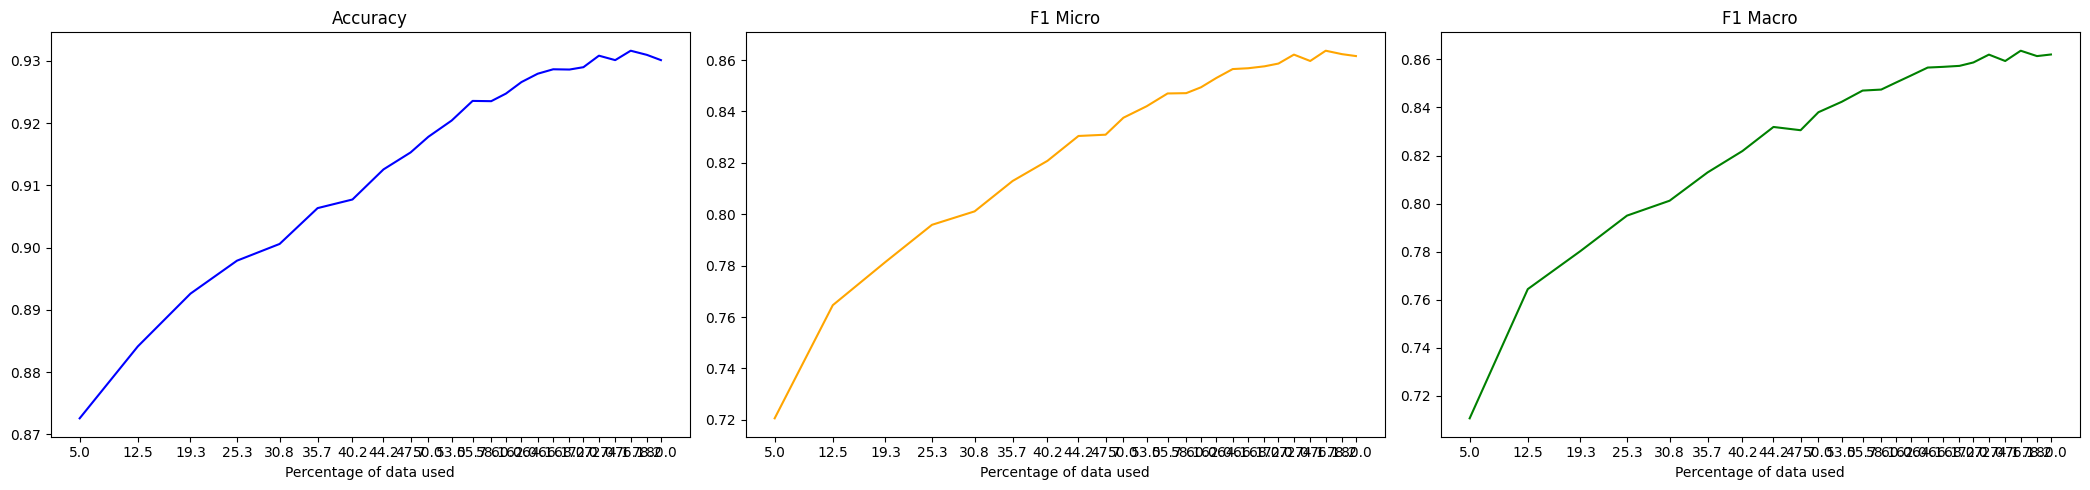

In [17]:
active_learning([50, 67, 42], 0)